## Imporerer pakker

In [1]:
import pandas as pd
import numpy as np



# Model Selection and Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error, r2_score, accuracy_score, f1_score, log_loss, confusion_matrix

from sklearn.compose import TransformedTargetRegressor

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor


# Classification Models
from sklearn.linear_model import LogisticRegression, HuberRegressor, BayesianRidge, LassoLars, PassiveAggressiveRegressor, TheilSenRegressor, SGDRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# Other Model Utilities
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import plot_tree

from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import make_scorer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import matplotlib.pyplot as plt
from sklearn import set_config
import plotly.express as px
from sklearn.compose import TransformedTargetRegressor
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.compose import TransformedTargetRegressor
from scipy import stats
from xgboost import XGBRegressor
from sklearn.preprocessing import TargetEncoder
import shap
from sklearn.preprocessing import MinMaxScaler
import pickle

/Users/jakobberg/anaconda3/envs/INF161/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Laster inn filer

In [2]:
train_df = pd.read_csv('train_df.csv')
val_df = pd.read_csv('validation_df.csv')
test_df = pd.read_csv('test_df.csv')

pd.set_option('display.max_columns', None)
pd.reset_option('display.float_format')

# Variabelutvinning

## Klassifikasjonsmodell for sykehusdød

In [3]:
# Forbered trenings- og valideringsdatasett
from preprocessing import prepare_data_for_death_classification, get_col_transformer
# Step 1: Train and save the classification model for imputing `sykehusdød`

# Prepare training and validation datasets for classification
X_train_classification, numeric_cols, categorical_cols, y_train = prepare_data_for_death_classification(train_df)
X_val_classification, _, _, y_val = prepare_data_for_death_classification(val_df)
X_test_classification, _, _, y_test = prepare_data_for_death_classification(test_df)

# Set up ColumnTransformer and classification pipeline
preprocessor = get_col_transformer(numeric_cols, categorical_cols, passthrough_cols=['demens'])
classification_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train the classifier
classification_pipeline.fit(X_train_classification, y_train)

# Validate and save the model
y_val_pred = classification_pipeline.predict(X_val_classification)
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

y_test_pred = classification_pipeline.predict(X_test_classification)
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy:.2f}")
# Save the classification model for future use
with open('sykehusdod_model.pkl', 'wb') as f:
    pickle.dump(classification_pipeline, f)

Validation Accuracy: 0.83
Test Accuracy: 0.81


In [4]:
if 'sykehusdød' in val_df.columns:
    val_df = val_df.drop(columns=['sykehusdød'])
if 'sykehusdød' in test_df.columns:
    test_df = test_df.drop(columns=['sykehusdød'])
# Prepare data for classification and predict `sykehusdød`
X_val_classification, _, _, _ = prepare_data_for_death_classification(val_df, prediction_mode=True)
X_test_classification, _, _, _ = prepare_data_for_death_classification(test_df, prediction_mode=True)

# Impute `sykehusdød`
val_df['sykehusdød'] = classification_pipeline.predict(X_val_classification)
test_df['sykehusdød'] = classification_pipeline.predict(X_test_classification)


## Oppretter nye variabler, og splitter target/features

In [5]:
from preprocessing import prepare_data_for_length_prediction

# Step 1: Prepare the data for length prediction
X_train, numeric_cols_train, categorical_cols_train, y_train = prepare_data_for_length_prediction(train_df, prediction_mode=False)
X_val, numeric_cols_val, categorical_cols_val, y_val = prepare_data_for_length_prediction(val_df, prediction_mode=False)
X_test, numeric_cols_test, categorical_cols_test, y_test = prepare_data_for_length_prediction(test_df, prediction_mode=False)

## Imputerer manglende verdier og oneHotEncoder kategoriske variabler

In [6]:

# We use the `numeric_cols_train` and `categorical_cols_train` from the prepare_data_for_length_prediction function
passthrough_cols = ['sykehusdød', 'demens', 'diabetes', 'omfattende_behandling']
col_transformer = get_col_transformer(numeric_cols_train, categorical_cols_train, passthrough_cols)

# Step 3: Fit and transform the training data
X_train_imputed = col_transformer.fit_transform(X_train)

# Step 4: Transform the validation and test data
X_val_imputed = col_transformer.transform(X_val)
X_test_imputed = col_transformer.transform(X_test)

# Step 5: Get feature names (numeric and one-hot encoded categorical columns)
# Step 5: Get feature names for numeric and one-hot encoded categorical columns
numeric_feature_names = numeric_cols_train  # Numeric columns
categorical_feature_names = col_transformer.named_transformers_['cat_pipeline']\
    .named_steps['one-hot-encoder'].get_feature_names_out([col for col in categorical_cols_train if col not in passthrough_cols])

# Combine numeric and categorical feature names
feature_names = list(numeric_feature_names) + list(categorical_feature_names) + passthrough_cols

# Step 6: Convert the transformed data back into DataFrames with the correct column names
X_train_imputed = pd.DataFrame(X_train_imputed, columns=feature_names)
X_val_imputed = pd.DataFrame(X_val_imputed, columns=feature_names)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=feature_names)


## Grunnlinjemodeller

In [19]:
baseline = DummyRegressor(strategy='mean')
baseline.fit(X_train, y_train)
prediction = baseline.predict(X_val)
rmse_baseline = root_mean_squared_error(y_val, prediction)
rmse_baseline

21.59611100410102

In [20]:
baseline2 = DummyRegressor(strategy='median')
baseline2.fit(X_train, y_train)
prediction = baseline2.predict(X_val)
rmse_baseline = root_mean_squared_error(y_val, prediction)
rmse_baseline

22.712103715253104

## Modellering

## Visualisering av actual vs predicted

In [7]:
def plot_actual_vs_pred(y_actual, y_pred, model_name):
    df = pd.DataFrame({'Actual': y_actual, 'Predicted': y_pred})
    fig = px.scatter(df, x='Actual', y='Predicted', title=f"{model_name}: Actual vs. Predicted")
    fig.add_shape(type="line", x0=df['Actual'].min(), y0=df['Actual'].min(),
                  x1=df['Actual'].max(), y1=df['Actual'].max(), line=dict(color='Red', dash='dash'))
    fig.show()


## RandomForestRegression

In [22]:
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train_imputed, y_train)

# Evaluate the model on validation data
y_val_pred_rf = model_rf.predict(X_val_imputed)
rmse_val_rf = (root_mean_squared_error(y_val, y_val_pred_rf))
print(f"RMSE on Validation Set (RandomForest): {rmse_val_rf:.3f}")
plot_actual_vs_pred(y_val, y_val_pred_rf, "Random Forest with Target Encoding")

RMSE on Validation Set (RandomForest): 21.204


## ExtraTreesRegressor

In [8]:
# Define and train ExtraTrees model
model_et = ExtraTreesRegressor(random_state=42)
model_et.fit(X_train_imputed, y_train)

# Evaluate on validation data
y_val_pred_et = model_et.predict(X_val_imputed)
rmse_val_et = (root_mean_squared_error(y_val, y_val_pred_et))
print(f"RMSE on Validation Set (ExtraTrees): {rmse_val_et:.3f}")
plot_actual_vs_pred(y_val, y_val_pred_et, "Random Forest with Target Encoding")

RMSE on Validation Set (ExtraTrees): 20.881


## Ridge

In [24]:
model_ridge = Ridge(random_state=42)  # You can adjust alpha as needed
model_ridge.fit(X_train_imputed, y_train)

# Predict and clip negative values to zero
y_val_pred = model_ridge.predict(X_val_imputed)
y_val_pred = np.maximum(y_val_pred, 0)
rmse_val = root_mean_squared_error(y_val, y_val_pred)
print(f"RMSE on Validation Set (Ridge with Clipping): {rmse_val:.3f}")
plot_actual_vs_pred(y_val, y_val_pred, "Random Forest with Target Encoding")

RMSE on Validation Set (Ridge with Clipping): 20.532


## Feature Importance for Ridge

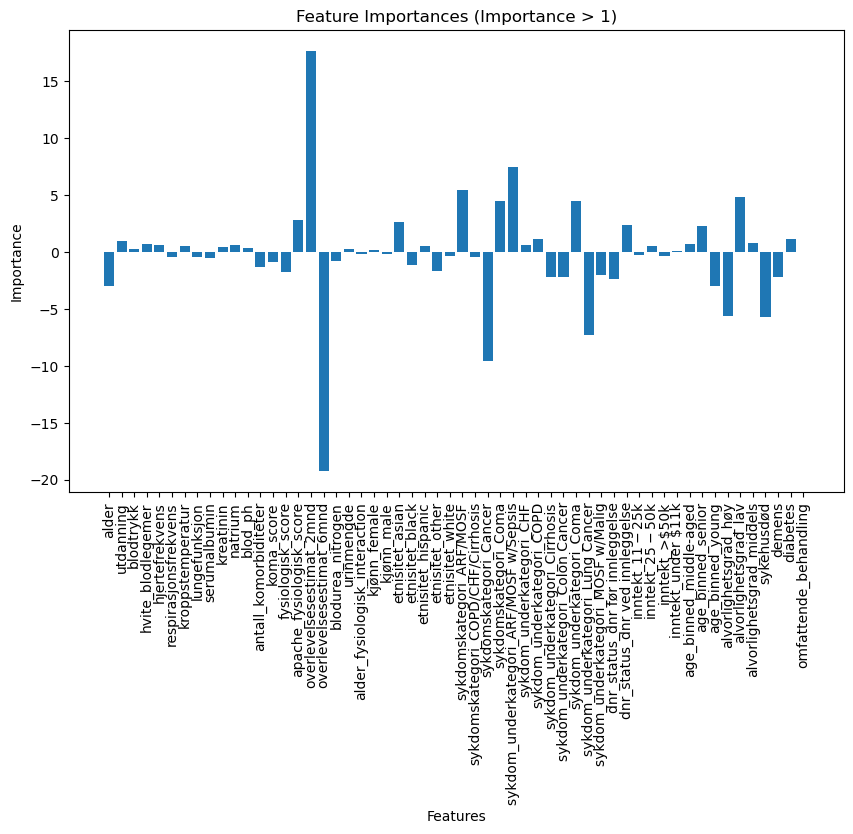

In [25]:
import matplotlib.pyplot as plt
import numpy as np
importance = model_ridge.coef_
# Ensure importance is an array and feature names align in length
assert len(importance) == len(feature_names), "Length mismatch between importance and feature_names"

# Filter for importance values greater than 1 (absolute)
filtered_importance = [imp for imp in importance if abs(imp) >= 0.03]
filtered_feature_names = [feature_names[i] for i in range(len(importance)) if abs(importance[i]) >= 0.03]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(filtered_importance)), filtered_importance)
plt.xticks(range(len(filtered_importance)), filtered_feature_names, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances (Importance > 1)")
plt.show()


## Finner best Alpha for Ridge

In [26]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import numpy as np

# Define the parameter grid for alpha
param_grid = {'alpha': np.logspace(-3, 3, 10)}  # Range from 0.001 to 1000

# Set up GridSearchCV with Ridge model
ridge_cv = GridSearchCV(
    estimator=Ridge(random_state=42),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,  # 5-fold cross-validation
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV on the training data
ridge_cv.fit(X_train_imputed, y_train)

# Get the best alpha and corresponding RMSE score
best_alpha = ridge_cv.best_params_['alpha']
best_rmse = -ridge_cv.best_score_  # Negative because of scoring convention
print(f"Best Alpha: {best_alpha}")
print(f"Best RMSE Score: {best_rmse:.3f}")

# Train a Ridge model with the best alpha and predict with clipping
best_ridge_model = Ridge(alpha=best_alpha, random_state=42)
best_ridge_model.fit(X_train_imputed, y_train)

# Predict and clip negative values to zero
y_val_pred_best = best_ridge_model.predict(X_val_imputed)
y_val_pred_best = np.maximum(y_val_pred_best, 0)
rmse_val_best = (root_mean_squared_error(y_val, y_val_pred_best))
print(f"Optimized RMSE on Validation Set with Clipping: {rmse_val_best:.3f}")


Best Alpha: 2.154434690031882
Best RMSE Score: 19.819
Optimized RMSE on Validation Set with Clipping: 20.531


## Hyperparametertuning ExtraTreesRegressor

In [27]:
from sklearn.model_selection import RandomizedSearchCV

X_train_full = X_train_imputed
X_val_full = X_val_imputed

# Define the parameter grid for ExtraTreesRegressor
param_grid_et = {
    'n_estimators': [100, 200, 500],  # Number of trees
    'max_depth': [10, 20, 50, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # Minimum samples required to be at a leaf node
    'bootstrap': [True, False]        # Whether bootstrap samples are used when building trees
}

# Initialize RandomizedSearchCV for ExtraTreesRegressor
random_search_et = RandomizedSearchCV(
    estimator=ExtraTreesRegressor(random_state=42),
    param_distributions=param_grid_et,
    n_iter=50,  # Number of random parameter combinations to try
    cv=5,  # 5-fold cross-validation
    scoring='neg_root_mean_squared_error',
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the random search model on the full feature set (X_train_full)
random_search_et.fit(X_train_full, y_train)

# Best hyperparameters
print(f"Best Hyperparameters: {random_search_et.best_params_}")

# Best RMSE score
best_rmse = -random_search_et.best_score_
print(f"Best RMSE Score: {best_rmse:.3f}")

# After finding the best model, use it to predict on the validation set
best_et_model = random_search_et.best_estimator_

# Predict on the validation set (with full features)
y_val_pred_best_et = best_et_model.predict(X_val_full)

# Calculate RMSE for the full feature set
rmse_best_et = root_mean_squared_error(y_val, y_val_pred_best_et)
print(f"RMSE on Validation Set with Full Features: {rmse_best_et:.3f}")

# Call the plot_actual_vs_pred function to visualize actual vs predicted values
plot_actual_vs_pred(y_val, y_val_pred_best_et, "Best ExtraTreesRegressor with Full Features")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   3.2s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   3.2s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   3.3s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.4s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.4s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.5s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.6s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators

## Hyperparamtertuning for ExtraTreesRegressor 

In [28]:
from sklearn.model_selection import GridSearchCV

# Use the best parameters as the center of the grid
param_grid_et_refined = {
    'n_estimators': [220, 250, 280],  # Around 200
    'max_depth': [35, 40, 45],        # Around 50
    'min_samples_split': [7, 8, 9], # Around 10
    'min_samples_leaf': [4, 5, 6],    # Around 4
    'bootstrap': [True]               # Keep as True based on RandomizedSearch result
}

# Initialize GridSearchCV for ExtraTreesRegressor
grid_search_et = GridSearchCV(
    estimator=ExtraTreesRegressor(random_state=42),
    param_grid=param_grid_et_refined,
    cv=5,  # 5-fold cross-validation
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit the grid search model on the full feature set (X_train_full)
grid_search_et.fit(X_train_full, y_train)

# Best hyperparameters from GridSearch
print(f"Best Hyperparameters from GridSearch: {grid_search_et.best_params_}")

# Best RMSE score from GridSearch
best_rmse_grid = -grid_search_et.best_score_
print(f"Best RMSE Score from GridSearch: {best_rmse_grid:.3f}")

# After finding the best model, use it to predict on the validation set
best_et_model_grid = grid_search_et.best_estimator_

# Predict on the validation set (with full features)
y_val_pred_best_et_grid = best_et_model_grid.predict(X_val_full)

# Calculate RMSE for the full feature set
rmse_best_et_grid = root_mean_squared_error(y_val, y_val_pred_best_et_grid)
print(f"RMSE on Validation Set with Full Features (GridSearch): {rmse_best_et_grid:.3f}")

# Visualize actual vs predicted values
plot_actual_vs_pred(y_val, y_val_pred_best_et_grid, "Best ExtraTreesRegressor with Full Features (GridSearch)")



Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END bootstrap=True, max_depth=35, min_samples_leaf=4, min_samples_split=7, n_estimators=220; total time=   6.9s
[CV] END bootstrap=True, max_depth=35, min_samples_leaf=4, min_samples_split=7, n_estimators=220; total time=   7.0s
[CV] END bootstrap=True, max_depth=35, min_samples_leaf=4, min_samples_split=7, n_estimators=220; total time=   7.0s
[CV] END bootstrap=True, max_depth=35, min_samples_leaf=4, min_samples_split=7, n_estimators=220; total time=   7.1s
[CV] END bootstrap=True, max_depth=35, min_samples_leaf=4, min_samples_split=7, n_estimators=220; total time=   7.2s
[CV] END bootstrap=True, max_depth=35, min_samples_leaf=4, min_samples_split=7, n_estimators=250; total time=   7.9s
[CV] END bootstrap=True, max_depth=35, min_samples_leaf=4, min_samples_split=7, n_estimators=250; total time=   8.1s
[CV] END bootstrap=True, max_depth=35, min_samples_leaf=4, min_samples_split=7, n_estimators=250; total time=   7.9s
[C

## Laster ned beste modell

In [29]:
with open('model.pkl', 'wb') as f:
    pickle.dump((best_et_model_grid, col_transformer, feature_names), f)

## ExtraTreesRegressor med log transformasjon av target variabel

In [30]:
import numpy as np
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Log-transform the target variable
y_train_log = np.log1p(y_train)  # log1p applies log(1 + y) to avoid issues with log(0)

# Define and train ExtraTrees model on the log-transformed target
model_et = ExtraTreesRegressor(random_state=42)
model_et.fit(X_train_imputed, y_train_log)

# Evaluate on validation data by predicting and applying the inverse log transformation
y_val_pred_log = model_et.predict(X_val_imputed)
y_val_pred_et = np.expm1(y_val_pred_log)  # Apply expm1 to reverse the log1p transformation

# Calculate RMSE on the original scale
rmse_val_et = root_mean_squared_error(y_val, y_val_pred_et)
print(f"RMSE on Validation Set (ExtraTrees with Log Transformation): {rmse_val_et:.3f}")



RMSE on Validation Set (ExtraTrees with Log Transformation): 21.013


## Hyperparamtertuning av ExtraTreesRegressor med log transformert target variabel

In [31]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.ensemble import ExtraTreesRegressor

y_train_log = np.log1p(y_train)

# Define the parameter grid for ExtraTreesRegressor
param_grid_et = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize RandomizedSearchCV for ExtraTreesRegressor
random_search_et = RandomizedSearchCV(
    estimator=ExtraTreesRegressor(random_state=42),
    param_distributions=param_grid_et,
    n_iter=50,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the random search model on the log-transformed target variable
random_search_et.fit(X_train_imputed, y_train_log)

# Best hyperparameters
print(f"Best Hyperparameters: {random_search_et.best_params_}")

# Get the best RMSE on the log-transformed scale
best_rmse_log = -random_search_et.best_score_
print(f"Best RMSE on Log Scale: {best_rmse_log:.3f}")

# Convert best RMSE on the log scale to approximate original scale RMSE
best_rmse_original_scale = np.expm1(best_rmse_log)  # Approximate to interpret scale
print(f"Approximate Best RMSE on Original Scale: {best_rmse_original_scale:.3f}")

# Use the best model to predict on the validation set
best_et_model = random_search_et.best_estimator_
y_val_pred_log = best_et_model.predict(X_val_imputed)

# Apply the inverse transformation to predictions
y_val_pred_et = np.expm1(y_val_pred_log)

# Calculate RMSE for the full feature set on original scale
rmse_val_et = root_mean_squared_error(y_val, y_val_pred_et)
print(f"RMSE on Validation Set with Log Transformation Applied: {rmse_val_et:.3f}")

# Plot actual vs predicted values
plot_actual_vs_pred(y_val, y_val_pred_et, "Best ExtraTreesRegressor with Log Transformation")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   4.2s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   4.2s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   4.3s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   6.3s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   6.3s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   6.3s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   6.4s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators

## Tester beste modellen på test-data

In [32]:
y_test_pred = best_et_model_grid.predict(X_test_imputed)
rmse = root_mean_squared_error(y_test, y_test_pred)
print(rmse)
plot_actual_vs_pred(y_test, y_test_pred, "Best ExtraTreesRegressor with Full Features")

21.77908940305225
